# Compute the risk of flooding from a threshold extracted form a frequency analysis of observed data

In this notebook, we combine the forecasting abilities and the time series analysis capabilities in a single seamless process to estimate the flood risk of a probabilistic forecast. As an example, we first perform a frequency analysis on an observed time series, then estimate the streamflow associated to a 2-year return period. We then perform a climatological ESP forecast (to ensure repeatability, but a realtime forecast would work too!) and estimate the probability of flooding (exceeding the threshold) given the ensemble of members in the probabilistic forecast.

In [1]:
%matplotlib inline

from birdy import WPSClient
from ravenpy.utilities.testdata import get_file
import os
import xarray as xr
from urllib.request import urlretrieve
from pathlib import Path
import datetime as dt
from matplotlib import pyplot as plt
import tempfile

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
finch_url = os.environ.get(
    "FINCH_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/finch/wps"
)
finch = WPSClient(finch_url)

Perform the time series analysis on observed data for the catchment using the frequency analysis WPS capabilities.

In [2]:
# Get the data that we will be using for the demonstration.
fn = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/fileServer/birdhouse/testdata/raven/raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"

# Perform the frequency analysis for various return periods. We compute 2, 5, 10, 25, 50 and 100 year return
# periods, but later on we will only compare the forecasts to the 2 year return period.
resp_fa = finch.freq_analysis(
    fn, variable="qobs", mode="max", t=(2, 5, 10, 25, 50, 100), dist="gumbel_r"
)
out, log, meta = resp_fa.get(asobj=True)

Threshold: 186.4


Text(25, 10, 'Flow threshold, set at 2-year return period')

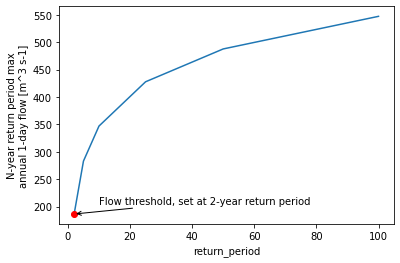

In [3]:
# Plot the results of the flows as a function of return period.
fig, ax = plt.subplots(1)
lines = out.q1maxannual.plot(ax=ax)

# Get 2-year return period from the frequency analysis
threshold = out.sel(return_period=2).q1maxannual.values
print(f"Threshold: {threshold:.1f}")

pt = ax.plot([2], [threshold], "ro")

ax.annotate(
    "Flow threshold, set at 2-year return period",
    (2, threshold),
    xytext=(25, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
)

## Probabilistic forecast

Let's first connect to the WPS server that performs hydrological modelling and forecasting.

Then we generate a series of forecasts based on the climatology of previous years.

In [4]:
raven_url = os.environ.get(
    "WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps"
)
wps = WPSClient(raven_url)
tmp = Path(tempfile.mkdtemp())

In [5]:
# Define some of the catchment properties. Could also be replaced by a call to the properties WPS.
basin_area = 4523.5
basin_longitude = -72.55
basin_latitude = 48.39
basin_elevation = 300.0

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = "GR4JCN"

# Since we've used GR4JCN, we need to provide that model's parameters.
model_parameters = "0.529, -3.396, 157.29, 1.072, 16.9, 0.947"

# Choose the forecast date. Each forecast will start with the same day and month.
# For example, jan-05-2001 will compare the climatology using all jan-05ths from the dataset)
fdate = dt.datetime(2003, 4, 13)

# The dataset to use to get the forecast timeseries:
# ts = str(get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc"))
duration = 30  # Length in days of the climatological ESP forecast

# Launch the climatology ESP on the remote server
resp = wps.climatology_esp(
    fdate,
    forecast_duration=duration,
    ts=fn,
    model_name=hydromodel,
    params=model_parameters,
    latitude=basin_latitude,
    longitude=basin_longitude,
    elevation=basin_elevation,
    area=basin_area,
)

# Get the link to the forecast file, that will be used to compute the flood risk for this particular event.
[forecast_url] = resp.get(asobj=False)
[forecast] = resp.get(asobj=True)

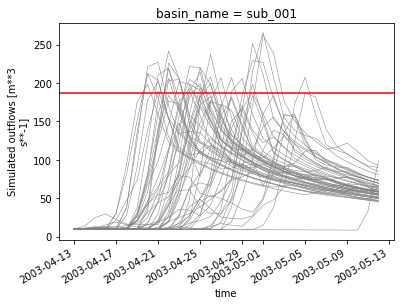

In [6]:
# Plot the forecasts and the 2-year threshold previously estimated
fig, ax = plt.subplots(1)
lines = forecast.q_sim.plot(ax=ax, hue="member", add_legend=False, color="gray", lw=0.5)
t = ax.axhline(threshold, color="red")

Text(0, 0.5, 'Flood risk')

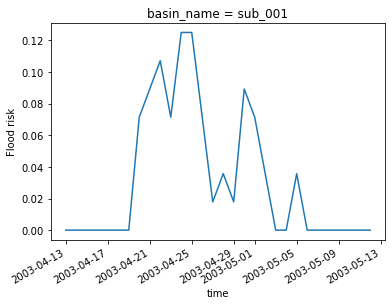

In [7]:
# Now compute the flood risk given the probabilistic forecast and the threshold associated to the 2-year return
# period.

threshold = out.sel(return_period=2).q1maxannual.values

# Run the flood forecast WPS to extract the probability of exceedance
resp_floodrisk = wps.forecast_floodrisk(
    fcst=forecast_url, name="q_sim", flood_level=threshold
)
[flood_risk] = resp_floodrisk.get(asobj=True)

# Extract the data and plot
fig, ax = plt.subplots(1)
l = flood_risk.q_sim.plot()
ax.set_ylabel("Flood risk")

### Results analysis
We can see from the above figure that there is a small risk of exceeding the 2-year return period for a set of dates during the forecast.